In [113]:
from bs4 import BeautifulSoup # to parse html
import pandas as pd

In [19]:
bigfoot_file = 'data/bigfoot_data.json'

with open(bigfoot_file) as f:
    raw_df = pd.read_json(f, lines=True)

In [20]:
raw_df.head()

,_id,url,html,time
0,{'$oid': '5939abbd2acdf6607095366c'},show_report.asp?id=13038,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:40 2017
1,{'$oid': '5939abbd2acdf6607095366d'},show_report.asp?id=8792,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
2,{'$oid': '5939abbd2acdf6607095366e'},show_report.asp?id=1255,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
3,{'$oid': '5939abbd2acdf6607095366f'},show_report.asp?id=11616,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
4,{'$oid': '5939abbe2acdf66070953670'},show_report.asp?id=637,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:42 2017


In [81]:
raw_df.shape[0]

4857

In [83]:
drop_indices = []

for i, x in enumerate(raw_df.html):
    if 'Media Article' in x:
        drop_indices.append(i)

In [86]:
good_df = raw_df.drop(drop_indices).reset_index()

In [87]:
soup = BeautifulSoup(good_df.html[0])

In [88]:
[x.text for x in soup.findAll('span')[0:5]]

['Geographical Index > United States > Alaska > Anchorage County > Report # 13038\xa0',
 'Report # 13038',
 '(Class A)',
 'Submitted  by  witness   on Saturday,\xa0November\xa012,\xa02005.',
 'Snowmobiler has encounter in deep snow near Potter, AK']

In [89]:
def build_header(str_lst):
    result = {}
    geographic = [x.strip() for x in str_lst[0].split('>')]
    geo_dict = {}
    geo_dict['region'] = geographic[1]
    geo_dict['state'] = geographic[2]
    geo_dict['detail'] = geographic[3]
    report = geographic[4]
    geo_dict['report'] = report.split(' ')[-1]
    geo_dict['report_class'] = str_lst[2]
    return geo_dict

In [90]:
build_header([x.text for x in soup.findAll('span')[0:5]])

{'region': 'United States',
 'state': 'Alaska',
 'detail': 'Anchorage County',
 'report': '13038',
 'report_class': '(Class A)'}

In [91]:
def build_details(str_lst):
    
    # empty list to store return key value pairs
    result = {}
    
    valid_columns = ['YEAR', 'SEASON', 'MONTH', 'STATE', 'COUNTY', 'LOCATION DETAILS',
       'NEAREST TOWN', 'NEAREST ROAD', 'OBSERVED', 'ALSO NOTICED',
       'OTHER WITNESSES', 'OTHER STORIES', 'TIME AND CONDITIONS',
       'ENVIRONMENT', 'DATE', 'extra']
    
    # flag to alter the way we build keys
    process_diff = False
    
    # empty array to store extra information if process_diff flag is True
    extra = []
    for i, x in enumerate(str_lst):
        # splits each line into a key, value string pair
        first, *second = x.split(':')
        
        if not first.isupper() and first not in valid_columns:    
            # checks if key isn't CAPS, if not we process the rest of the html differently
            process_diff = True
            
        if not process_diff:
            # we join the second part in case there exists a colon ":" inside the raw text
            result[first] = (' '.join(second)).strip()
            
        else:
            # append each extra line to a general array
            extra.append(x)
    
    # combine all extra values into a single long string
    result['extra'] = ' '.join(extra)
    remove_keys = []
    for key in result.keys():
        if key not in valid_columns:
            remove_keys.append(key)
    for key in remove_keys:
        result.pop(key)
    return result

In [92]:
soup = BeautifulSoup(good_df.html[4251])

build_details([x.text for x in soup.find_all('p')])

{'YEAR': '1965',
 'SEASON': 'Summer',
 'MONTH': 'August',
 'STATE': 'Washington',
 'COUNTY': 'Yakima County',
 'LOCATION DETAILS': 'parker washington out side of yakima washington',
 'NEAREST TOWN': 'parker out side of yakima',
 'NEAREST ROAD': 'the old yakima road to wapato',
 'OBSERVED': 'when i was a kid we lived out side of yakima out in the country by parker a little town out side of yakima . Near the yakima river matter of fact we were so close to the river that in the spring when the river rose we had to move the animals an go into town .the woods were thick we had a pig pen it was a long ways away from the house really thickly wooded. all the time we lived there you wood hear shrill whistling whistling in the bushesat this time we were maybe ten years old never heard of bigfoot before im 48 years old now so it was long ago.It was in the ninteen sixtys way before roger patterson nobody knew about bigfoot . Well anyway us kids were sent into the woods to feed the cows at the big 

In [93]:
def process_one(row):
    soup = BeautifulSoup(row)
    details = build_details([x.text for x in soup.find_all('p')])
    header = build_header([x.text for x in soup.find_all('span')[0:5]])
    joined = {}
    joined.update(details)
    joined.update(header)
    return joined
    

In [94]:
for i, row in enumerate(raw_df.html):
    if 'SEE PHOTOS FROM SILVER STAR MOUNTAIN' in row:
        print(i)

4251


In [112]:
processed = []

for i, row in enumerate(good_df.html):
    try:
        processed.append(process_one(row))
    except Exception as e:
        pass
        #print(f'row: {i}', e)

Text(0.5, 1.0, 'Column Counts')

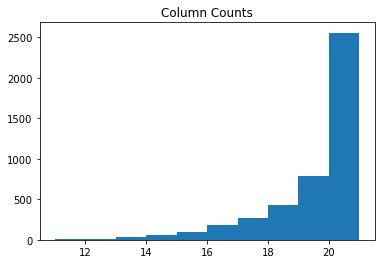

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist([len(x.keys()) for x in processed])
ax.set_title('Column Counts')

In [98]:
df = pd.DataFrame(processed)

In [99]:
df.columns

Index(['YEAR', 'SEASON', 'MONTH', 'STATE', 'COUNTY', 'LOCATION DETAILS',
       'NEAREST TOWN', 'NEAREST ROAD', 'OBSERVED', 'ALSO NOTICED',
       'OTHER WITNESSES', 'OTHER STORIES', 'TIME AND CONDITIONS',
       'ENVIRONMENT', 'extra', 'region', 'state', 'detail', 'report',
       'report_class', 'DATE'],
      dtype='object')

In [100]:
df.head()

,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,...,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,extra,region,state,detail,report,report_class,DATE
0,2004,Winter,February,Alaska,Anchorage County,Up near powerline clearings east of Potter Mar...,Anchorage / Hillside,No real roads in the area,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Anchorage County,13038,(Class A),NaN
1,2003,Winter,December,Alaska,Anchorage County,"Few houses on the way, a power relay station. ...",Anchorage,Dowling,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...",...,no,"Started at 11, ended at about 3-3 30. Weather ...","A pine forest, with a bog or swamp on the righ...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Anchorage County,8792,(Class B),Friday night
2,1998,Fall,September,Alaska,Bethel County,"45 miles by air west of Lake Iliamna, Alaska i...",NaN,NaN,My hunting buddy and I were sitting on a ridge...,nothing unusual,...,NaN,NaN,Call Iliamna Air taxi for lat & Long of Long L...,,United States,Alaska,Bethel County,1255,(Class B),3
3,2004,Summer,July,Alaska,Bristol Bay County,"Approximately 95 miles east of Egegik, Alaska....",Egegik,NaN,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,...,"I've only heard of one other story, from an ol...","Approximately 12 30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Bristol Bay County,11616,(Class B),20
4,2000,Summer,June,Alaska,Cordova-McCarthy County,"On the main trail toward the glacier, before t...","Kennikot, Alaska",not sure,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,...,None,About 12 00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...,Follow-up investigation report: Summary of com...,United States,Alaska,Cordova-McCarthy County,637,(Class A),16


In [101]:
df[(df.report_class != '(Class A)') & (df.report_class != '(Class B)') & (df.report_class != '(Class C)')]

,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,...,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,extra,region,state,detail,report,report_class,DATE


In [107]:
len(df['MONTH'].value_counts()) <= 12

True

In [111]:
df['STATE'].value_counts()

Washington        523
California        393
Florida           277
Ohio              253
Oregon            232
Illinois          215
Michigan          204
Texas             193
Missouri          129
Georgia           118
Kentucky          108
Pennsylvania      108
Colorado          107
West Virginia      98
New York           95
Alabama            91
Tennessee          88
Arizona            83
Arkansas           83
Indiana            75
North Carolina     75
Oklahoma           72
Virginia           71
Idaho              66
Wisconsin          65
Minnesota          61
New Jersey         58
Utah               57
Iowa               47
Montana            43
New Mexico         39
Kansas             39
South Carolina     37
Louisiana          36
Maryland           33
Wyoming            27
Massachusetts      25
Mississippi        21
Alaska             20
Nebraska           14
New Hampshire      11
Connecticut        11
South Dakota       11
Maine              10
Vermont             8
Nevada    